In [1]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
import sklearn.utils
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr



from collections import defaultdict
import math
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
import scikits.bootstrap as boot

from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion
from sklearn.cross_validation import LeaveOneOut
from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import _get_term_features, _get_last_n_action_features, \
            _get_action_features, _get_repeatition_features, _get_balance_features, documents2feature_vectors

/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
constraints = ['delta2_no_users_attacker_in_conv', 'delta2_no_users']
#constraints = ['delta2_none', 'delta2_no_users', 'delta3_none', 'delta3_no_users']
#constraints = ['none', 'no_users', 'attacker_in_conv', 'no_users_attacker_in_conv']

In [4]:
constraint = constraints[0]
suffix = '_cleaned'#'_cleaned_verified'

In [5]:
UNIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/unigram50%s.pkl"%(constraint, suffix)
BIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/bigram100%s.pkl"%(constraint, suffix)
UNIGRAMS_LIST = cPickle.load(open(UNIGRAMS_FILENAME, "rb"))
BIGRAMS_LIST = cPickle.load(open(BIGRAMS_FILENAME, "rb"))

In [6]:
STATUS = {4: ['founder', 'sysop'], 
      3: ['accountcreator', 'bureaucrat', 'checkuser'], \
      2: [ 'abusefilter', 'abusefilter-helper', 'autoreviewer', 'extendedmover',  \
        'filemover', 'import', 'oversight', 'patroller', \
        'reviewer','rollbacker','templateeditor','epadmin', 'epcampus', 'epcoordinator',\
        'epinstructor', 'eponline'],\
      1: ['massmessage-sender', 'ipblock-exempt', 'extendedconfirmed',\
            'autoconfirmed', 'researcher', 'user']}
ASPECTS = ['age', 'status', 'comments_on_same_talk_page', 'comments_on_all_talk_pages',\
        'edits_on_subjectpage', 'edits_on_wikipedia_articles', 'history_toxicity']

In [7]:
attacker_profile_ASPECTS = ['proportion_of_being_replied',\
            'proportion_of_utterance_over_all', 'total_length_of_utterance', \
            'maximum_toxicity', 'age', 'status', 'comments_on_all_talk_pages',\
            'edits_on_wikipedia_articles', 'history_toxicity', \
            'self_modification', 'other_modification', 'pron_you_usage', \
            'gratitude_usage', 'max_negativity']

In [8]:
with open("/scratch/wiki_dumps/expr_with_matching/user_features/all.json") as f:
    inp = json.load(f)
user_features = {}
for conv, users in inp:
    user_features[conv] = users

In [9]:
with open('feature_extraction/utils/lexicons') as f:
    LEXICONS = json.load(f)

In [10]:
def _user_features(document, user_features, ASPECTS, STATUS):
    EPS = 0.001

    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
        start_time = min(start_time, action['timestamp_in_sec'])

    users = []
    user_infos = {}

    total_utterances = 0
    ret = {'has_anon': 0, 'has_bot':0}
    action_dict = {}
    replied = {}
    for action in actions:
        if action['timestamp_in_sec'] == end_time:
            continue
        total_utterances += 1
        action_dict[action['id']] = action
        if 'user_text' in action:
            users.append(action['user_text'])
        else:
            ret['has_anon'] = 1
            
    total = {}
    lst = {}
    for aspect in ASPECTS:
        ret['%s_gap'%aspect] = 0
        ret['min_%s'%aspect] = np.inf
        ret['max_%s'%aspect] = 0
        ret['%s_entropy'%aspect] = 1
        total[aspect] = 0
        ret['%s_variance'%aspect] = 1
        lst[aspect] = []

    bot = ['bot']

    for u in users:
        user_info = {'proportion_of_being_replied' : 0,\
                    # 'proportion_of_replies_to_others': 0, 
                'proportion_of_utterance_over_all': 0, 'total_length_of_utterance': 0, \
                 'maximum_toxicity' : 0, \
                     # 'bot_modification': 0,
                   'self_modification': 0, 'other_modification': 0, 'pron_you_usage': 0, \
                    'gratitude_usage' : 0, 'max_negativity': 0}
        if u in user_features:
            user = user_features[u]
            if 'blocked' in user:
                ret['has_blocked'] = 1
                user_info['blocked'] = 1
            if 'registration' in user:
                user_info['age'] = max(0, (start_time - user['registration']) / 60 / 60 / 24 / 30)
               # [0.000000001, 6, 12, 60, 180]
                
                if user_info['age']:
                    if user_info['age'] < 1:
                        user_info['age'] = 1
                    elif user_info['age'] <= 6:
                        user_info['age'] = 6
                    elif user_info['age'] <= 12:
                        user_info['age'] = 12
                    elif user_info['age'] <= 18:
                        user_info['age'] = 18
            else:
                ret['has_anon'] = 1
                user_info['anon'] = 1
                user_info['age'] = 0
            level = 0
            if 'groups' in user:
                for g in user['groups']:
                    if g in bot:
                        ret['has_bot'] = 1
                        level = -1
                        break
                    for l in STATUS.keys():
                        if g in STATUS[l]:
                            level = max(level, l)
            if level >= 0:
                user_info['status'] = level
                user_info['comments_on_same_talk_page'] = user['edits_on_this_talk_page']
                user_info['comments_on_all_talk_pages'] = user['edits_on_wikipedia_talks']
                user_info['edits_on_subjectpage'] = user['edits_on_subjectpage']
                user_info['edits_on_wikipedia_articles'] = user['edits_on_wikipedia_articles']
            else:
                user_info['bot'] = 1
            user_info['history_toxicity'] = user['history_toxicity']
        else:
            ret['has_anon'] = 1
            user_info['anon'] = 1
            for aspect in ASPECTS:
                user_info[aspect] = 0
        if 'status' in user_info:# and not('anon' in user_info): # is bot
            for aspect in ASPECTS:
                ret['max_%s'%aspect] = max(ret['max_%s'%aspect], user_info[aspect])
                ret['min_%s'%aspect] = min(ret['min_%s'%aspect], user_info[aspect])
                total[aspect] += user_info[aspect]
                lst[aspect].append(user_info[aspect])
        user_infos[u] = user_info
    for action in actions:
        if action['timestamp_in_sec'] == end_time:
            continue
        if 'user_text' in action:
            user = action['user_text']
            user_infos[user]['total_length_of_utterance'] += len(action['unigrams'])
            user_infos[user]['maximum_toxicity'] = max(user_infos[user]['maximum_toxicity'], action['score'])
            user_infos[user]['pron_you_usage'] += action['pron_you']
            user_infos[user]['proportion_of_utterance_over_all'] += 1
            user_infos[user]['gratitude_usage'] += sum([not(str.find(u.lower(), 'thank')==-1)  for u in action['unigrams']])
            if not(action['polarity'] == []):
                cur_neg = max([p['neg'] for p in action['polarity']])
            else:
                cur_neg = 0
            user_infos[user]['max_negativity'] = max(user_infos[user]['max_negativity'], cur_neg)
            if not('replyTo_id' not in action or action['replyTo_id'] == None):
                replied[action['replyTo_id']] = 1
               # user_infos[user]['proportion_of_replies_to_others'] += 1
            
            if action['comment_type'] == 'COMMENT_MODIFICATION':
                if 'parent_id' in action and action['parent_id'] in action_dict:
                    if not('bot' in user):
                     #   user_infos[user]['bot_modification'] += 1
            #        else:
                        parent = action_dict[action['parent_id']]
                        if 'user_text' in parent:
                            if parent['user_text'] == user:
                                user_infos[user]['self_modification'] += 1 
                            else:
                                user_infos[user]['other_modification'] += 1
                        else:
                            user_infos[user]['other_modification'] += 1

                else:
                     user_infos[user]['other_modification'] += 1
    for key in replied.keys():
        if 'user_text' in action_dict[key]:
            user = action_dict[key]['user_text']
            user_infos[user]['proportion_of_being_replied'] += 1
    for u in user_infos.keys():
        for key in ['proportion_of_being_replied', \
                   'self_modification', 'other_modification']:
            user_infos[u][key] /= user_infos[u]['proportion_of_utterance_over_all']
        user_infos[u]['proportion_of_utterance_over_all'] /= total_utterances
    entropies = {}
    for aspect in ASPECTS:
        if len(lst[aspect]):
            ret['%s_gap'%(aspect)] = ret['max_%s'%aspect] - ret['min_%s'%aspect]
            ret['%s_variance'%(aspect)] = np.var(lst[aspect])
            if len(lst[aspect]) > 1 and total[aspect]:
                l = len(lst[aspect])
                for x in lst[aspect]:
                    if x == 0:
                        a = EPS
                    else:
                        a = x
                ret['%s_entropy'%aspect] += a / total[aspect] * math.log(a / total[aspect]) / math.log(l)
        if np.isinf(ret['min_%s'%aspect]):
            ret['min_%s'%(aspect)] = 0
        entropies['%s_entropy'%aspect] = ret['%s_entropy'%aspect]
 #   print(ret['max_age'])
  #  return entropies, user_infos
    return ret, user_infos#ret, user_infos # non_starter_attacker_profiles

In [11]:
def attacker_profile(document, user_infos, collected, ASPECTS):
    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    attacker = None
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
            if 'user_text' in action:
                attacker = action['user_text']
            else:
                attacker = None
        start_time = min(start_time, action['timestamp_in_sec'])
    appeared = False
    for action in actions:
        if action['timestamp_in_sec'] < end_time:
            if 'user_text' in action and action['user_text'] == attacker:
                appeared = True
    blocked = False
    profile = {}
    for aspect in ASPECTS:
        profile[aspect] = 0

    if attacker and attacker in user_infos:
        profile = user_infos[attacker]
    cnts = {}
    for aspect in ASPECTS:
        mini = np.inf
        maxi = 0
        for u in user_infos.keys():
            if aspect in user_infos[u]:
                mini = min(user_infos[u][aspect], mini)
                maxi = max(user_infos[u][aspect], maxi)
        if attacker == None or 'anon' in profile:
            cnts[aspect] = 'Anonymous'
            continue
        if not(appeared):
            cnts[aspect] = 'New Comer'
            continue
        if 'bot' in profile:
            cnts[aspect] = 'Bot'
            continue
        if maxi > mini:
            if profile[aspect] == mini:
                cnts[aspect] = 'Min'
            else:
                if profile[aspect] == maxi:
                    cnts[aspect] = 'Max'
                else:
                    cnts[aspect] = 'In the Middle'
        else:
            cnts[aspect] = 'No Gap'
        cnts['experience'] = profile['comments_on_all_talk_pages']
    return cnts, blocked

In [39]:
def train_svm(X, y, C_svm, C_lr, matched_pairs):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [a * C_svm for a in [1, 3, 5, 7, 9]]}]
    linear_tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [a * C_lr for a in [5, 7]]}]
    train_indices = []
    test_indices = []
    y_l = len(y)
    for pair in matched_pairs:
        train = []
        test = []
        for ind in range(y_l):
            if ind in pair:
                test.append(ind)
            else:
                train.append(ind)
        train_indices.append(train)
        test_indices.append(test)
    print(len(train_indices), len(test_indices))
   # print([len(t) for t in test_indices])
    lpo = zip(train_indices, test_indices)
    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=lpo, scoring = 'accuracy')
    clf.fit(X, y)
    
 #   logreg = GridSearchCV(linear_model.LogisticRegression(), linear_tuned_parameters, cv=lpo, scoring= 'accuracy')
 #   logreg.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    cur = 0
    best_scores = []
    for params, mean_score, scores in clf.grid_scores_:
      #  print(sum([1 if s == 1 else 0 for s in scores]))
      #  print(sum([1 if s == 0 else 0 for s in scores]))
      #  print(sum([1 if s == 0.5 else 0 for s in scores]))
        print("%0.3f for %r"
              % (mean_score, params), boot.ci(scores, method='pi')) #scipy.stats.sem(scores) * 1.96, params))
        if mean_score > cur:
            best_scores = scores
            cur = mean_score
    print(cur)
    return best_scores
    
 #   for params, mean_score, scores in logreg.grid_scores_:
 #       print("%0.3f (+/-%0.03f) for %r"
 #             % (mean_score, scores.std() * 1.96, params))

#    print(scores.mean())
#    print scores

In [13]:
def preprocess(actions):
    action_dict = {}   
    ret = []
    for action in actions:
        action_dict[action['id']] = action
        if action['comment_type'] == 'COMMENT_MODIFICATION':
            if not('parent_id' in action) or not(action['parent_id'] in action_dict):
                action['comment_type'] = 'COMMENT_ADDING'
                action['parent_id'] = None 
        ret.append(action)
    return ret

In [14]:
documents = []
conv_dict= {}
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/all%s.json'%(constraint, suffix)) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        
        actions = sorted(conversation['action_feature'], \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
        conversation['action_feature'] = preprocess(conversation['action_feature'])
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        conv_dict[conv_id] = actions
        snapshot = generate_snapshots(actions)
        conversation['snapshot_len'] = len(snapshot)
        
        documents.append((conversation, clss, conv_id)) 

In [15]:
random.shuffle(documents)

In [16]:
matched_pairs = []
doc_dic = {}
title_dic = defaultdict(list)
cnt = 0
max_gap = 0
max_l_gap = 0
deleted = {}
cleaned = []
feature_sets = []
for ind, doc in enumerate(documents):
    conversation, clss, conv_id = doc
    actions = sorted(conversation['action_feature'], \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
    conversation['action_feature'] = preprocess(conversation['action_feature'])
    end_time = max([a['timestamp_in_sec'] for a in actions])
    actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
    if clss:
        matched_id = actions[0]['bad_conversation_id']
    else:
        matched_id = actions[0]['good_conversation_id']
    users = len(set([a['user_text'] if 'user_text' in a else None for a in actions]) - set([None]))
    users1 = len(set([a['user_text'] if 'user_text' in a else None for a in conv_dict[matched_id]]) - set([None]))
    if not(users == users1) or not(len(actions) == len(conv_dict[matched_id])):
  #  if not(abs(users1 - users) < 1) or not(abs(len(actions) - len(conv_dict[matched_id])) < 1):
  #      or \
  #      len(actions) <= 3:
  #      print(len(actions))
  #      print(len(conv_dict[matched_id]))
  #      print([a['user_text'] if 'user_text' in a else None for a in actions])
  #      print([a['user_text'] if 'user_text' in a else None for a in conv_dict[matched_id]])
        cnt += 1
        max_gap = max(max_gap, abs(users - users1))
        max_l_gap = max(max_l_gap, abs(len(conv_dict[matched_id]) - len(actions)))
    else:
        feature_sets.append(({'length': len(actions), 'no_users': users}, clss))
        cleaned.append(doc)
        title_dic[conversation['action_feature'][0]['page_title']].append(ind)
    doc_dic[conv_id] = ind
matched_pairs = list(title_dic.values())
print(len(matched_pairs))
print(cnt / 2, max_gap, max_l_gap)

353
0.0 0 0


In [22]:
print(len(cleaned))
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/all_cleaned.json'%(constraint), 'w') as f:
    for line in cleaned:
        conversation, clss, conv_id = line
        f.write(json.dumps((conv_id, clss, conversation)) + '\n')

776


In [17]:
len(feature_sets) / 2

388.0

In [30]:
documents = cleaned

In [18]:
def get_features(BOW = False, Conversational = False, User = False, ACTION_FEATURE = False, SNAPSHOT_LEN = False):
    feature_sets = []
    bow_features = []
    colorcodes = {}
    color_cnt = 0
    for pair in documents:
        conversation, clss, conv_id = pair
        feature_set = {}
        actions = conversation['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        actions = sorted(actions, \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))[::-1]
        feature_set.update(_get_term_features(actions, UNIGRAMS_LIST, BIGRAMS_LIST))
        for k in feature_set.keys():
            colorcodes[k] = color_cnt
        bow_features.append((copy.deepcopy(feature_set), clss))
    conv_features = []
    color_cnt += 1
    assigned = False
    for pair in documents:
        conversation, clss, conv_id = pair
        feature_set = {}
        actions = conversation['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        actions = sorted(actions, \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))[::-1]
        feature_set.update(_get_last_n_action_features(actions, 3, LEXICONS, ACTION_FEATURE))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
        color_cnt += 1
        feature_set.update(_get_action_features(actions, LEXICONS))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
        color_cnt += 1          
        feature_set.update(_get_repeatition_features(actions))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
        color_cnt += 1
        actions = actions[::-1]
        try:
            feature_set.update(_get_balance_features(actions))
        except:
            print([(a['id'], a['parent_id'], a['comment_type']) if 'parent_id' in a \
                   else (a['id'], a['comment_type'])for a in actions])
            break
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
        color_cnt += 1
        assiganed = True
        if SNAPSHOT_LEN:
            feature_set['snapshot_len'] = conversation['snapshot_len']
        conv_features.append((copy.deepcopy(feature_set), clss))
    participant_features = []
    starter_attack_profiles = {0: [], 1:[]}
    non_starter_attack_profiles = {0: [], 1: []}
    blocks = []
    user_info = []
    for ind, pair in enumerate(documents):
        conversation, clss, conv_id = pair
        actions = conversation['action_feature']
        start_time = min([a['timestamp_in_sec'] for a in actions])
        end_time = max([a['timestamp_in_sec'] for a in actions])
        for a in actions:
            if a['timestamp_in_sec'] == start_time:
                if 'user_text' in a:
                    starter = a['user_text']
                else:
                    starter = 'anon'
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a:
                    ender = a['user_text']
                else:
                    ender = 'anon'
        feature_set, user_infos = _user_features(conversation, user_features[conv_id], ASPECTS, STATUS)
        for k in feature_set.keys():
            if not(k in colorcodes):
                colorcodes[k] = color_cnt
        color_cnt += 1
        p, b = attacker_profile(conversation,  user_infos, feature_set, attacker_profile_ASPECTS)
        user_info.append(user_infos)
        if starter == ender:
            starter_attack_profiles[clss].append(p)
        else:
            non_starter_attack_profiles[clss].append(p)
        blocks.append(int(b))
        participant_features.append((copy.deepcopy(feature_set), clss))
    feature_sets = []

    for ind, pair in enumerate(documents):
        conversation, clss, conv_id = pair
        feature_set = {}
        if BOW:
            feature_set.update(bow_features[ind][0])
        if Conversational:
            feature_set.update(conv_features[ind][0])
        if User:
            feature_set.update(participant_features[ind][0])
        feature_sets.append((feature_set, clss))
    return user_info, starter_attack_profiles, non_starter_attack_profiles, feature_sets, colorcodes

In [38]:
# BOW, Conversational, User, ACTION_FEATURE, SNAPSHOT_LEN

In [19]:
COLOR = ["#60883f","#79409f","#bf6435","#6476bf","#84313d","#d05088"]

In [20]:
def top_coefficients(classifier, feature_names, colorcodes, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features][::-1]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    y_neg_pos = []
    y_pos_pos = []
    x_pos_pos = []
    x_neg_pos = []
    for ind in range(top_features):
        y_neg_pos.append(ind*3)
        y_pos_pos.append(ind*3)
        x_pos_pos.append(coef[top_positive_coefficients[ind]])
        x_neg_pos.append(coef[top_negative_coefficients[ind]])
    # create plot
    plt.figure(figsize=(20, 10))
    f, (ax2, ax1) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
    ax2.plot(x_neg_pos, y_neg_pos, 'ro', alpha = 0.7)

    ax1.plot(x_pos_pos, y_pos_pos, 'bo', alpha = 0.7)
    for ind in range(top_features):
        ax1.annotate(feature_names[top_positive_coefficients[ind]], xy=(x_pos_pos[ind], y_pos_pos[ind]), \
                     xytext=(x_pos_pos[ind]+0.003, y_pos_pos[ind]), \
                    color=COLOR[colorcodes[feature_names[top_negative_coefficients[ind]]]])
        ax2.annotate(feature_names[top_negative_coefficients[ind]], xy=(x_neg_pos[ind], y_neg_pos[ind]), \
                     xytext=(x_neg_pos[ind]+ 0.003, y_neg_pos[ind]), \
                     color=COLOR[colorcodes[feature_names[top_negative_coefficients[ind]]]])
    ax1.set_xlim(right=0.15)
    ax2.set_xlim(right=0.025)
    ax1.set_yticks([])
    ax2.set_yticks([])
    names = np.array(feature_names)
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

In [22]:
X, y, feature_names = documents2feature_vectors(feature_sets)
len_only_scores = train_svm(X, y, 0.1, 0.001, matched_pairs)

Fitting
353 353
Best parameters set found on development set:

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:



/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)


0.500 for {'C': 0.1} [ 0.5  0.5]


/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)


0.500 for {'C': 0.30000000000000004} [ 0.5  0.5]


/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)


0.500 for {'C': 0.5} [ 0.5  0.5]


/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)


0.500 for {'C': 0.7000000000000001} [ 0.5  0.5]
0.500 for {'C': 0.9} [ 0.5  0.5]
0.5


/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)


In [40]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(Conversational=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
conv_only_scores = train_svm(X, y, 0.001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
353 353


ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

In [33]:
len(feature_names)

37

In [32]:
classifier = svm.LinearSVC(C=0.005)
classifier.fit(X, y)
top_neg, top_pos = top_coefficients(classifier, feature_names, colorcodes, 1)

IndexError: list index out of range

In [89]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True, Conversational=True, User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
full_scores = train_svm(X, y, 0.001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
353 353
Best parameters set found on development set:

LinearSVC(C=0.007, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.523 (+/-0.035) for {'C': 0.001}
0.527 (+/-0.037) for {'C': 0.005}
0.531 (+/-0.037) for {'C': 0.007}
0.531 (+/-0.037) for {'C': 0.009000000000000001}
0.530927835052


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [26]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
bow_scores = train_svm(X, y, 0.00001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
353 353
Best parameters set found on development set:

LinearSVC(C=7.000000000000001e-05, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

Grid scores on development set:



/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.501 for {'C': 1e-05} [ 0.47111493  0.53541076]
0.515 for {'C': 3.0000000000000004e-05} [ 0.48425064  0.54957507]
0.519 for {'C': 5e-05} [ 0.48937677  0.55618508]
0.524 for {'C': 7.000000000000001e-05} [ 0.49480642  0.56208687]
0.519 for {'C': 9e-05} [ 0.48961284  0.55664036]
0.524484536082


In [28]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
user_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
353 353
Best parameters set found on development set:

LinearSVC(C=0.03, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:



/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.530 for {'C': 0.01} [ 0.50566572  0.55888304]
0.536 for {'C': 0.03} [ 0.51031971  0.56468366]
0.535 for {'C': 0.05} [ 0.5079084   0.56090652]
0.534 for {'C': 0.07} [ 0.50539593  0.56131121]
0.527 for {'C': 0.09} [ 0.50032038  0.55473493]
0.536082474227


In [47]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(User=True, Conversational=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
user_conv_scores = train_svm(X, y, 0.001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
316 316
Best parameters set found on development set:

LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.555 (+/-0.035) for {'C': 0.001}
0.551 (+/-0.035) for {'C': 0.005}
0.543 (+/-0.035) for {'C': 0.007}
0.551 (+/-0.035) for {'C': 0.009000000000000001}
0.554913294798


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [38]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True, Conversational=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
bow_conv_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
3040 3040
Best parameters set found on development set:

LinearSVC(C=0.0005, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.537 (+/-0.011) for {'C': 0.0001}
0.538 (+/-0.013) for {'C': 0.0005}
0.537 (+/-0.015) for {'C': 0.0007}
0.535 (+/-0.016) for {'C': 0.0009000000000000001}
0.537640782454


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [32]:
scipy.stats.wilcoxon(conv_only_scores, bow_scores)

WilcoxonResult(statistic=8016.5, pvalue=0.063086335586640951)

In [33]:
scipy.stats.wilcoxon(conv_only_scores, user_only_scores)

WilcoxonResult(statistic=8204.0, pvalue=0.049717744140561106)

# Ploting Utilities

In [34]:
def plot_profiles(profiles, clss, ASPECTS):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['Min', 'Max', 'In the Middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(10,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+0.2 for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['bad_', 'good_']
    for clss in [0, 1]:
        for aspect in ASPECTS:
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
            for p in profiles[clss]:
                bads[clss][catergories[p[aspect]]][-1] += 1
        previous = [0 for a in ASPECTS]
        for ind,bad in enumerate(bads[clss][:3]):
            bad = [b / total for b in bad]
            bads[clss][ind] = bad
            ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ii, b in enumerate(bad):
                previous[ii] += b
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize='small')
        bar_l = [b+bar_width for b in bar_l]
        

    ax.set_ylabel("Percentage among All the Cases")
    ax.set_xlabel("Aspect")
    Xticks = ASPECTS
    plt.xticks(tick_pos, Xticks)
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()

In [35]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')

In [36]:
def plot_profiles1(profiles, ASPECTS, experience=-1):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['Min', 'Max', 'In the Middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(20,10))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+bar_width for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['bad_', 'good_']
    mins = [[], []]
    cnts = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    rects = []
    for clss in [0, 1]:
        for aspect in ASPECTS:
            cur = []
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
                cnts[clss][ind].append(0)
            for p in profiles[clss]:
            #    if not('experience') in p or p['experience'] <= experience:
            #        continue
                bads[clss][catergories[p[aspect]]][-1] += 1
                cnts[clss][catergories[p[aspect]]][-1] += 1
                if catergories[p[aspect]] == 0:
                    cur.append(1)
                elif catergories[p[aspect]] < 3:
                    cur.append(0)
            mins[clss].append(cur)
        previous = [0 for a in ASPECTS]
        first_three = [0 for a in ASPECTS]
        for bad in bads[clss][:3]:
            for ii, b in enumerate(bad):
                first_three[ii] += b
        for ind,bad in enumerate(bads[clss][:3]):
            for ii, b in enumerate(bad):
                if first_three[ii]: bad[ii] = bad[ii] / first_three[ii]
            bads[clss][ind] = bad
            rects = ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ind, rect in enumerate(rects):
                ax.text(rect.get_x() + rect.get_width()/2., (bad[ind] / 3 + previous[ind]),
                '%.2f' % bad[ind],
                ha='center', va='bottom')
            for ii, b in enumerate(bad):
                previous[ii] += b
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize='small')
        bar_l = [b+bar_width for b in bar_l]
        if clss:
            print('Good Total:')
        else:
            print('Bad Total:')
        for ii,aspect in enumerate(ASPECTS):
            print(aspect, first_three[ii])
    ax.set_ylabel("Percentage among All the Cases")
    ax.set_xlabel("Aspect")
    Xticks = ASPECTS

    plt.xticks(tick_pos, Xticks)
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()
  #  for aspect in ASPECTS:
  #      print(aspect, first_three[0], first_three[1])

    print('Test 1')
    for ind, aspect in enumerate(ASPECTS):
        print(aspect)
        print('Average in Ggap: ', np.mean(mins[1][ind]))
        print('Average of Bgap: ', np.mean(mins[0][ind]))
        if np.mean(mins[1][ind]) == 1 or np.mean(mins[1][ind]) == 0:
            continue
        print(scipy.stats.mannwhitneyu(mins[0][ind], mins[1][ind]))
        print('\n')
    print('Test 2')
    clss = 0
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
     #   print(cnts[clss][0][ind], cnts[clss][1][ind])
    print('\n')
    print('Test 3')
    clss = 1
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
    

In [25]:
plot_profiles(profiles, 1, attacker_profile_ASPECTS)

NameError: name 'plot_profiles' is not defined

In [48]:
def activation_of_features(feature_sets, documents, interested_lst):
    # attacker activates : 1
    # other activates : -1
    # both : 0
    # In the case of it gets activates
    activators = [{}, {}]
    for f in interested_lst:
        activators[0][f] = []
        activators[1][f] = []
    for ind, pair in enumerate(feature_sets):
        f, clss = pair
        conversation, clss, conv_id = documents[ind]
        actions = sorted(conversation['action_feature'], key=lambda k: k['timestamp_in_sec'])
        end_time = max([a['timestamp_in_sec'] for a in actions])
        attacker = None
        for action in actions:
            if action['timestamp_in_sec'] == end_time:
                if 'user_text' in action:
                    attacker = action['user_text']
                else:
                    attacker = 'anon'
        for in_f in interested_lst:
            if not(f[in_f]):
                continue
            if in_f[:8] == 'UNIGRAM_':
                unigram = in_f[8:]
                attacker_did = 0
                other = 0
                for action in actions:
                    if action['timestamp_in_sec'] < end_time and unigram in action['unigrams']\
                       and (action['comment_type'] == 'SECTION_CREATION' or action['comment_type'] == 'COMMENT_ADDING'):
                        if 'user_text' in action and action['user_text'] == attacker:
                            attacker_did = 1
                        elif not('user_text' in action) and attacker == 'anon':
                            attacker_did = 1
                        else: other = -1
                    #    print(action['user_text'], attacker)
                activators[clss][in_f].append(other + attacker_did)
    for in_f in interested_lst:
        print(scipy.stats.mannwhitneyu(activators[0][in_f], activators[1][in_f]))
        ones = 0 
        negs = 0
        als = 0
        name = ['bad', 'good']
        for clss in [0, 1]:
            print(name[clss])
            for f in activators[clss][in_f]:
                ones += (f == 1)
                negs += (f == -1)
                als += (f == 0)
            print('attacker:', ones, ' other: ', negs, ' both:', als)
            total = ones+negs+als
            print(ones / total, negs / total, als/ total)
        print('\n')

In [125]:
activation_of_features(feature_sets, documents, ['UNIGRAM_what', 'UNIGRAM_who'])

MannwhitneyuResult(statistic=53055.5, pvalue=0.32699763703786133)
bad
attacker: 114  other:  144  both: 61
0.3573667711598746 0.45141065830721006 0.19122257053291536
good
attacker: 235  other:  287  both: 136
0.35714285714285715 0.43617021276595747 0.2066869300911854


MannwhitneyuResult(statistic=24898.0, pvalue=0.30770270738264993)
bad
attacker: 91  other:  106  both: 28
0.40444444444444444 0.4711111111111111 0.12444444444444444
good
attacker: 171  other:  212  both: 69
0.37831858407079644 0.4690265486725664 0.15265486725663716




Bad Total:
proportion_of_being_replied 174
proportion_of_utterance_over_all 160
total_length_of_utterance 178
maximum_toxicity 178
age 167
status 106
comments_on_all_talk_pages 149
edits_on_wikipedia_articles 155
history_toxicity 155
self_modification 23
other_modification 13
pron_you_usage 132
gratitude_usage 43
max_negativity 151
Good Total:
proportion_of_being_replied 151
proportion_of_utterance_over_all 145
total_length_of_utterance 153
maximum_toxicity 153
age 146
status 89
comments_on_all_talk_pages 139
edits_on_wikipedia_articles 140
history_toxicity 141
self_modification 19
other_modification 14
pron_you_usage 106
gratitude_usage 38
max_negativity 123


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


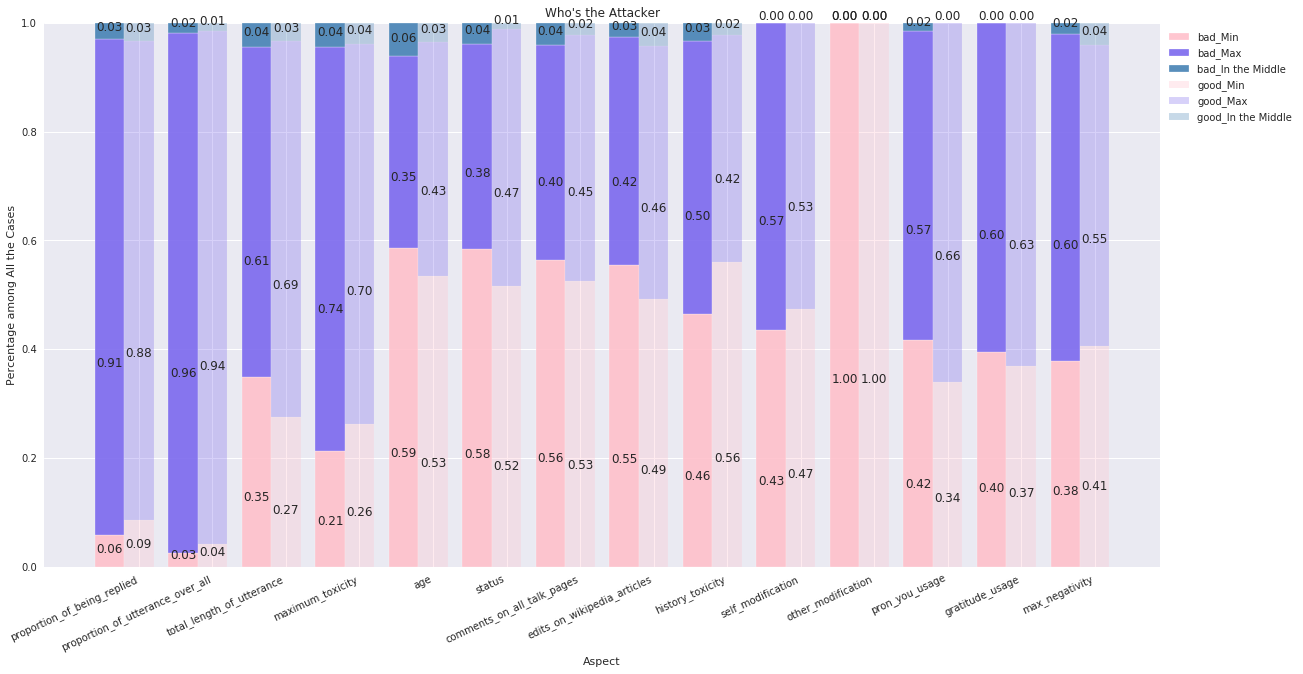

Test 1
proportion_of_being_replied
Average in Ggap:  0.0860927152318
Average of Bgap:  0.0574712643678
MannwhitneyuResult(statistic=12761.0, pvalue=0.15849816051146709)


proportion_of_utterance_over_all
Average in Ggap:  0.0413793103448
Average of Bgap:  0.025
MannwhitneyuResult(statistic=11410.0, pvalue=0.21221229129626684)


total_length_of_utterance
Average in Ggap:  0.274509803922
Average of Bgap:  0.348314606742
MannwhitneyuResult(statistic=12612.0, pvalue=0.075032646367784436)


maximum_toxicity
Average in Ggap:  0.261437908497
Average of Bgap:  0.213483146067
MannwhitneyuResult(statistic=12964.0, pvalue=0.15324938760523604)


age
Average in Ggap:  0.534246575342
Average of Bgap:  0.586826347305
MannwhitneyuResult(statistic=11550.0, pvalue=0.17535812682533503)


status
Average in Ggap:  0.516853932584
Average of Bgap:  0.584905660377
MannwhitneyuResult(statistic=4396.0, pvalue=0.17149187382374942)


comments_on_all_talk_pages
Average in Ggap:  0.525179856115
Average of Bgap:  0.

In [37]:
plot_profiles1(starter_attack_profiles, attacker_profile_ASPECTS)

Bad Total:
proportion_of_being_replied 166
proportion_of_utterance_over_all 162
total_length_of_utterance 169
maximum_toxicity 170
age 153
status 106
comments_on_all_talk_pages 155
edits_on_wikipedia_articles 159
history_toxicity 156
self_modification 30
other_modification 7
pron_you_usage 136
gratitude_usage 58
max_negativity 151
Good Total:
proportion_of_being_replied 207
proportion_of_utterance_over_all 189
total_length_of_utterance 208
maximum_toxicity 210
age 196
status 136
comments_on_all_talk_pages 193
edits_on_wikipedia_articles 190
history_toxicity 195
self_modification 37
other_modification 17
pron_you_usage 167
gratitude_usage 72
max_negativity 174


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


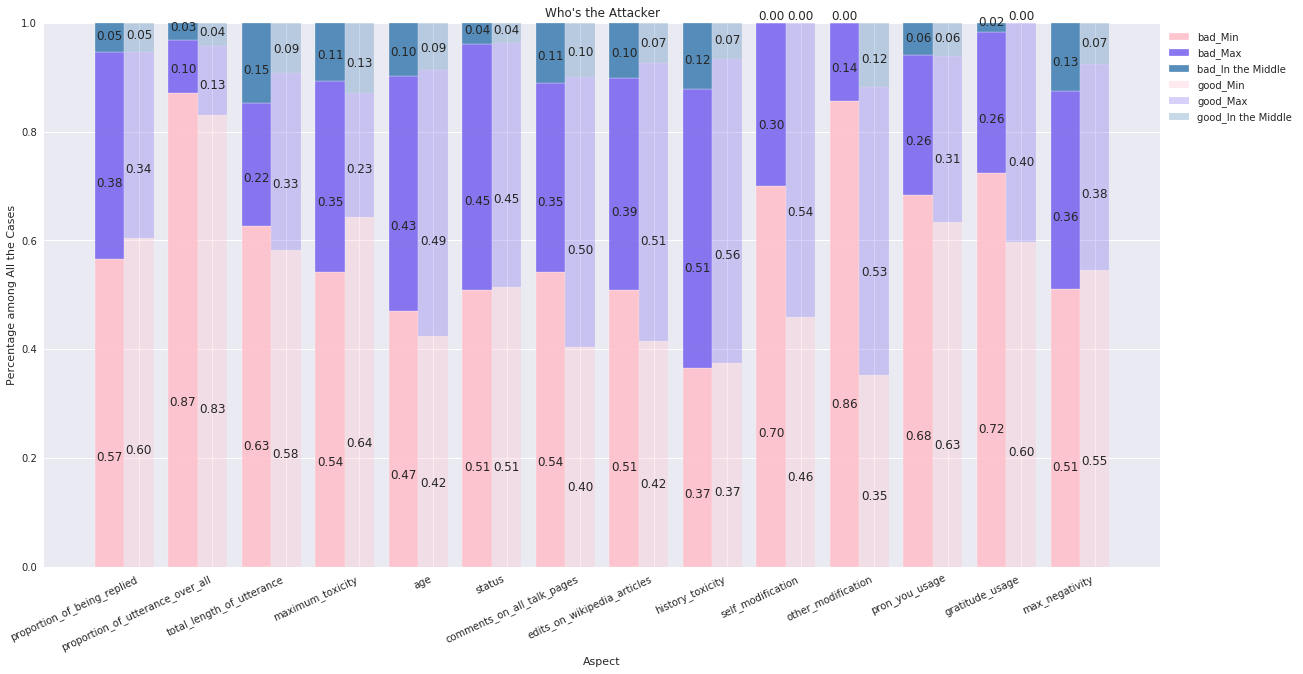

Test 1
proportion_of_being_replied
Average in Ggap:  0.6038647343
Average of Bgap:  0.566265060241
MannwhitneyuResult(statistic=16535.0, pvalue=0.23225657211394857)


proportion_of_utterance_over_all
Average in Ggap:  0.830687830688
Average of Bgap:  0.87037037037
MannwhitneyuResult(statistic=14701.5, pvalue=0.1508476368199676)


total_length_of_utterance
Average in Ggap:  0.581730769231
Average of Bgap:  0.627218934911
MannwhitneyuResult(statistic=16776.5, pvalue=0.18522052820782658)


maximum_toxicity
Average in Ggap:  0.642857142857
Average of Bgap:  0.541176470588
MannwhitneyuResult(statistic=16035.0, pvalue=0.022407704835753835)


age
Average in Ggap:  0.423469387755
Average of Bgap:  0.470588235294
MannwhitneyuResult(statistic=14287.5, pvalue=0.1901971082627204)


status
Average in Ggap:  0.514705882353
Average of Bgap:  0.509433962264
MannwhitneyuResult(statistic=7170.0, pvalue=0.46805222380706502)


comments_on_all_talk_pages
Average in Ggap:  0.40414507772
Average of Bgap:  0.

In [39]:
plot_profiles1(non_starter_attacker_profiles, attacker_profile_ASPECTS)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


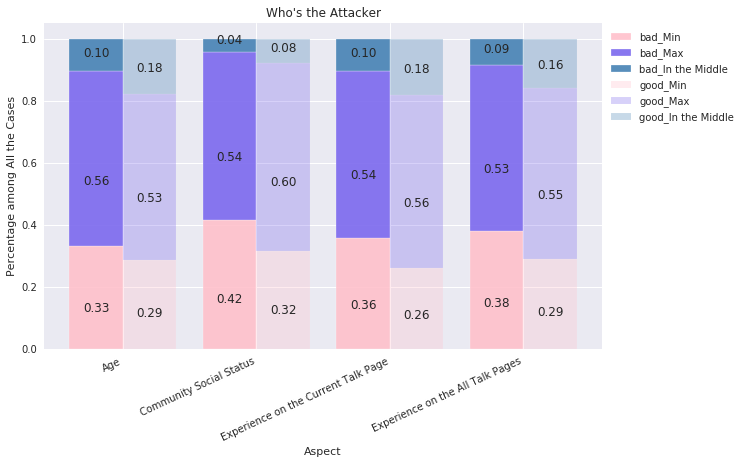

age 1382 959
status 1382 959
comments_on_all_talk_pages 1382 959
edits_on_wikipedia_articles 1382 959
Test 1
age
Average in Ggap:  0.207941483804
Average of Bgap:  0.333333333333
MannwhitneyuResult(statistic=128061.0, pvalue=0.00014816578325557882)


status
Average in Ggap:  0.158307210031
Average of Bgap:  0.261437908497
MannwhitneyuResult(statistic=131320.5, pvalue=0.00048570891969643067)


comments_on_all_talk_pages
Average in Ggap:  0.189655172414
Average of Bgap:  0.359477124183
MannwhitneyuResult(statistic=121555.5, pvalue=2.4375555359398886e-07)


edits_on_wikipedia_articles
Average in Ggap:  0.206896551724
Average of Bgap:  0.37908496732
MannwhitneyuResult(statistic=121209.0, pvalue=3.7266021517668413e-07)


Test 2
age : 0.00351999328744
status : 0.251322103475
comments_on_all_talk_pages : 0.0259668373227
edits_on_wikipedia_articles : 0.0616493425108


Test 3
age : 2.98730653179e-24
status : 7.55830254033e-21
comments_on_all_talk_pages : 3.25317772329e-34
edits_on_wikipedia_art

In [45]:
plot_profiles1(profiles, 1, ['age', 'status', 'comments_on_all_talk_pages',\
        'edits_on_wikipedia_articles'], 5)

In [25]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

In [47]:
def plot_feature_distribution(all_features, features):
    cnts = {}
    for f in features:
        cnts[f] = {0:[], 1:[]}

    for pair in all_features:
        fea, clss = pair
        for f in fea.keys():
            if f in features:
                cnts[f][clss].append(fea[f])
    
    print('finish collecting')
    means_0 = []
    means_1 = []
    stds_0 = []
    stds_1 = []
    for f in features:
        means_0.append(np.mean(cnts[f][0]))
        means_1.append(np.mean(cnts[f][1]))
        stds_0.append(np.std(cnts[f][0]))
        stds_1.append(np.std(cnts[f][1]))
    
    
    N = len(features)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    plt.figure(figsize=(15, 5))
    rects1 = plt.bar(ind, means_0, width, color='r', yerr=stds_0)

    rects2 = plt.bar(ind + width, means_1, width, color='y', yerr=stds_1)

    # add some text for labels, title and axes ticks
  #  plt.set_ylabel('Average')
    plt.title('Predictive Features by group')
    plt.xticks(ind + width / 2, features, rotation=60, ha='right')
 #   plt.set_xticklabels(features)

    plt.legend((rects1[0], rects2[0]), ('Bad Conversation', 'Good Conversations'))

    plt.show()

In [102]:
def get_examples(documents, pairs, the_feature, the_value, number, wanted_class, answer, profiles, wanted_id, top_pos, top_neg):
    conversations = {}
    for ind, doc in enumerate(documents):
        conversation, clss, conv_id = doc
        conversations[conv_id] = ind
    cnt = 0
    acc = 0
    for ind, pair in enumerate(pairs):
        fea, clss = pair
        conversation, clss, conv_id = documents[ind]
        if clss:
            matched_id = conversation['action_feature'][0]['bad_conversation_id']
        else:
            matched_id = conversation['action_feature'][0]['good_conversation_id']
        the_match = conversations[matched_id]
        f = the_feature
     #   if documents[ind][2] == wanted_id:
    #    if fea[f] >= the_value and clss == wanted_class and \
    #        pairs[the_match][0][f] < the_value and answer[ind] == clss and \
    #        answer[the_match] == 1 - clss:
        if clss == wanted_class and answer[ind] == clss and \
            answer[the_match] == 1 - clss and not('user' in conversation['action_feature'][0]['page_title'].lower()):
            number -= 1
            ls = []
            for ii in [ind, the_match]:
                conv_id = documents[ii][2]
                actions = sorted(documents[ii][0]['action_feature'], \
                                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
                end_time = max([a['timestamp_in_sec'] for a in actions])
            #    actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
                snapshot = generate_snapshots(actions)
                ls.append(len(snapshot))
                the_action = {}
                for a in actions:
                    the_action[a['id']] = a
           #     print([(a['content'], a['user_text'], a['id'], a['comment_type']) for a in actions])
                if number == 0:
                    print(actions[0]['conversation_id'])
                #    print(pairs[ii][0][f])
                #    print('positives')
                #    for ff in top_pos[::-1]:
                #        print(ff, pairs[ii][0][ff])
                #    print('negatives')
                #    for ff in top_neg:
                #        print(ff, pairs[ii][0][ff])
                    for s in snapshot:
                        #  print(the_action[s['id']]['content_words'])
                        print(s['content'])
                        print(s['user_text'], profiles[ii][s['user_text']])
                        print(s['relative_replyTo'])
                    #      print(the_action[s['id']]['pron_you'])
                    print('\n')
            if (ls[0] - ls[1] <= 1) and (ls[0] - ls[1] >= -1):
                cnt += 2
                acc += (answer[ind] == clss)
                acc += (answer[the_match] == 1 - clss)
            if number == 0:
                return
 #   print(cnt, acc / cnt)

In [216]:
classifier = linear_model.LogisticRegression(C=0.007)
classifier.fit(X, y)
ans = classifier.predict(X)
get_examples(documents, feature_sets, 'user_last_action_has_polite', 1,1, 0, ans, user_info, '166342666.20.23', top_pos, top_neg)

157597403.0.0
 ==uncover==
74.192.20.87 {'proportion_of_being_replied': 0.5, 'proportion_of_utterance_over_all': 0.5, 'total_length_of_utterance': 60, 'maximum_toxicity': 0.12057688943610838, 'self_modification': 0.0, 'other_modification': 0.0, 'pron_you_usage': 1, 'gratitude_usage': 0, 'max_negativity': 0, 'anon': 1, 'age': 0, 'status': 0, 'comments_on_same_talk_page': 3, 'comments_on_all_talk_pages': 20, 'edits_on_subjectpage': 0, 'edits_on_wikipedia_articles': 217}
-1
are there any old ags on here who can verify that "uncovering" is a tradition? and by old ags i mean at least going back to the 70's. im pretty sure that uncovering is reserved for the national anthem, prayer, and if you are a true texan, texas our texas.   —Preceding [Wikipedia:Signatures@unsigned] comment added by 
74.192.20.87 {'proportion_of_being_replied': 0.5, 'proportion_of_utterance_over_all': 0.5, 'total_length_of_utterance': 60, 'maximum_toxicity': 0.12057688943610838, 'self_modification': 0.0, 'other_modific

In [188]:
###### classifier = linear_model.LogisticRegression(C=0.007)
classifier.fit(X, y)
ans = classifier.predict(X)
#get_examples(documents, feature_sets, 'has_content_repeat', 1, 3, 1, ans)
get_examples(documents, feature_sets, 'user_last_action_has_polite', 1,23, 1, ans)

93622588.1469.1469
1
 ==References==
65.118.187.102
-1
 I'm removing unverified/unreferenced stuff from this article. Too bad that's nearly all of it. Try to reference all of this [WP:NOR@original research].
65.118.187.102
0
 :It is easier to get things referenced by leaving a tag on the page as opposed to almost blanking it. I'm going to restore it with a verifiability tag.  [Wikipedia:Editor review/The Hybrid@R]
The Hybrid
1
Someone want to explain to me how a professional wrestling slang term needs an "original research" tag? This whole event is ridiculous. It's like what happened to the [Vic Grimes] article where someone kept tagging every line in the article with "citation needed." This article has been around for 2 years, so why is it that NOW, because one person, who's not only on a school IP address, but is also acting completely childish by blanking the page (which is clearly [WP:VAND#Types_of_vandalism@blatant vandalism]) has the right to suddenly say "this article needs orig

In [55]:
def get_tile(num, tiles):
    for ind, t in enumerate(tiles):
        if num <= t:
            return ind

In [56]:
def get_values(aspect, feature_sets):
    values = []
    for pair in feature_sets:
        f, clss = pair
        values.append(f['min_%s'%(aspect)])
        values.append(f['max_%s'%(aspect)])
    values = np.array(values)
    return values

In [57]:
def discrepancy_heatmap_total(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        data[mini][maxi] += clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1]:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(total_d[::-1], annot=True)
    #sns.heatmap(data[::-1], annot=True)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()

In [32]:
aspect = 'age'
convs = {}
deleted = {}
good = []
bad = []
good_ages = []
bad_ages = []
EPS = 0
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    action = conversation['action_feature'][0]
    if False: #f['min_%s'%aspect] >= 6 or f['has_anon'] == 1:
        deleted[conv_id] = 1
        if clss:
            deleted[action['bad_conversation_id']] = 1
        else:
            deleted[action['good_conversation_id']] = 1   
print(len(deleted))
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    if conv_id in deleted:
        continue
    mini = f['min_%s'%aspect]
    if mini < 6:
        if clss:
            good.append(f['max_%s'%aspect] - mini)
        else:
            bad.append(f['max_%s'%aspect] - mini)
  #  for user in user_info[ind].keys():
  #      if clss and 'age' in user_info[ind][user]:
  #          good_ages.append(user_info[ind][user][aspect])
  #      else:
  #          bad_ages.append(user_info[ind][user][aspect])

0


In [33]:
# average age

In [34]:
print(len(good), len(bad))

257 283


In [35]:
print(np.mean(good), np.mean(bad), scipy.stats.mannwhitneyu(good, bad))
print(np.mean(good_ages), np.mean(bad_ages), scipy.stats.mannwhitneyu(good_ages, bad_ages))

33.029664532 27.2448653727 MannwhitneyuResult(statistic=31642.0, pvalue=0.0045156875387029087)
nan nan MannwhitneyuResult(statistic=0.0, pvalue=0.0)


/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yiqing/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [71]:
gaplst = []
labellst = []
for pair in feature_sets:
    f, clss = pair
    gaplst.append(f['history_toxicity_entropy'])#'min_%s'%aspect])
    labellst.append(clss)

In [72]:
pearsonr(gaplst, labellst)

(0.10690776333325319, 2.0015048412524615e-06)

In [38]:
goods = []
bads = []
for doc in documents:
    conversation, clss, conv_id = doc
    actions = conversation['action_feature']
    start_time = min([a['timestamp_in_sec'] for a in actions])
    end_time = max([a['timestamp_in_sec'] for a in actions])
    for a in actions:
        if a['timestamp_in_sec'] == start_time:
            if 'user_text' in a:
                starter = a['user_text']
            else:
                starter = 'anon'
        if a['timestamp_in_sec'] == end_time:
            if 'user_text' in a:
                ender = a['user_text']
            else:
                ender = 'anon'
    if clss:
        goods.append(int(starter == ender))
    else:
        bads.append(int(starter == ender))
print(np.mean(goods), np.mean(bads),scipy.stats.wilcoxon(goods, bads))

0.395325203252 0.512195121951 WilcoxonResult(statistic=49335.0, pvalue=3.0972230185431e-07)


In [39]:
def discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    gaps = defaultdict(list)
    gaplst = []
    labellst = []
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
        cur_gap =  f['max_%s'%aspect] - f['min_%s'%aspect]
        if True: #f['min_%s'%aspect] < 10:
            gaplst.append(f['status_entropy'])#'min_%s'%aspect])
            labellst.append(1-clss)
        # age
  #      if cur_gap < 1:
  #          log_val = 0
  #      if cur_gap < 5:
  #          log_val = 5
  #      elif cur_gap < 10:
  #          log_val = 10
  #      elif cur_gap < 50:
  #          log_val = 50
  #      else: log_val = 150
    # edits
        if cur_gap > 0:
            log_val = int(math.log(cur_gap) / math.log(10))
            if log_val == 1:
                log_val = 2
            if log_val == 6:
                log_val = 5
        else:
            log_val = 0
        gaps[log_val].append(1-clss)
   #     print(mini,maxi, tiles)

        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data, gaps, gaplst, labellst

In [40]:
def discrepancy_heatmap_status(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    normal_vs_normal = []
    normal_vs_all_admins = []
    normal_vs_page_admins = []
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        if mini == 1 and maxi == 1:
            normal_vs_normal.append(1-clss)
        if mini == 1 and maxi > 1:
            normal_vs_all_admins.append(1-clss)
        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data, normal_vs_normal, normal_vs_all_admins

In [41]:
# propencity of attacking
def propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, the_bin):
    data = []
    total_d = []
    total_t = len(tiles)
    the_attacker = []
    attacker_gap = defaultdict(list)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
        the_attacker.append([])
    for ind, pair in enumerate(documents):
        f, clss, conv_id = pair
        actions = f['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        attacker = None
        for a in actions:
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a:
                    if aspect in user_info[ind][a['user_text']]:
                        last = user_info[ind][a['user_text']][aspect]
                        attacker = a['user_text']
                    else:
                        if 'bot' in user_info:
                            last = 'bot'
                        else:
                            last = None
                else:
                    last = None
                break
        maxi = 0
        avg = []
        for a in actions:
            if a['timestamp_in_sec'] < end_time and 'user_text' in a \
               and not(a['user_text'] == attacker) and aspect in user_info[ind][a['user_text']]:
                maxi = max(maxi, user_info[ind][a['user_text']][aspect])
                avg.append(user_info[ind][a['user_text']][aspect])
        if last == None or isinstance(last, str):
            last_val = 0
        else:
            last_val = last
        avg = np.median(avg)
      #  if feature_sets[ind][0]['max_%s'%(aspect)] < last_val:
      #      print(last, feature_sets[ind][0]['max_%s'%(aspect)], clss, conv_id, 'bot' in user_info[ind][attacker])
        the_gap = avg - last_val
        if the_gap > the_bin[1]:
            the_gap = 2
        elif the_gap > the_bin[0]:
            the_gap = 1
        elif the_gap <= the_bin[0] and the_gap >= -the_bin[0]:
            the_gap = 0
        elif the_gap < -the_bin[0] and the_gap >= -the_bin[1]:
            the_gap = -1
        else: the_gap = -2
        attacker_gap[the_gap].append(1-clss)
        if last == None or isinstance(last, str): 
            global_rank = 0
          #  if  last == 'bot':
            local_rank = 4
        else:
            global_rank = get_tile(last, tiles)
            vals = []
            appeared = False
            for a in actions:
                if a['timestamp_in_sec'] < end_time and 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                    vals.append(user_info[ind][a['user_text']][aspect])
                    if a['user_text'] == attacker:
                        appeared = True
            #'Min', 'Max', 'In the middle', 'Anonymous', 'New Comer', 'Bot'
            if not(appeared): 
                local_rank = 3
                print('NOT APPEARED')
            elif last == min(vals):
                local_rank = 0
            elif last == max(vals):
                local_rank = 1
            else:
                local_rank = 2
        the_attacker[global_rank].append(1-clss)
        maxi = get_tile(feature_sets[ind][0]['max_%s'%aspect], tiles)
        data[global_rank][maxi] += (1-clss)
        total_d[global_rank][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    mask=np.isnan(data)
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, annot=True, mask=mask)
    plt.ylabel('The Attacker')
    plt.xlabel('The Maximum')
    tile_legends = tile_legends
    local_pos = ['Min', 'Max', 'In the middle', 'New Comer', 'Bot']
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends[::-1], rotation=60)
    plt.xticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    print(total_d)
    plt.show()
    return the_attacker, attacker_gap

In [42]:
def attacker_plot(attacker, tile_legends):

    data_m=np.array([np.mean(a) for a in attacker])   #(Means of your data)
    data_df=np.array([2] * len(attacker))   #(Degree-of-freedoms of your data)
    data_sd=np.array([np.std(a) for a in attacker])   #(Standard Deviations of your data)
    intervals = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a)) for a in attacker]
    err_l = [np.mean(a) - statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[0] for a in attacker]
    err_u = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[1] - np.mean(a) for a in attacker]
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    plt.errorbar([i for i in range(len(attacker))], data_m, yerr=[err_l, err_u])
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('Likelyhood of a user in a certain group attack')
    plt.show()

In [43]:
def attacker_plot(attacker, tile_legends):
    
    num_bads = sum([sum(a) for a in attacker])
    num_goods = sum([len(a) - sum(a) for a in attacker])
    data_b=np.array([(sum(a) / num_bads) for a in attacker])   #(Means of your data)
    data_g = np.array([(len(a) - sum(a)) / num_goods for a in attacker])
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    N = len(attacker)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35

    plt.bar(ind, data_b, width,  color='r', alpha=0.7)

    plt.bar(ind + width, data_g, width, color='b', alpha=0.7)
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('title')
    plt.show()

In [44]:
def attacker_plot_gap(attacker, tile_legends, aspect, SAMPLETIME=1000):
    gaps = attacker
    keys = sorted(attacker)
    data_m=np.array([np.mean(gaps[a]) for a in keys])   #(Means of your data)
    print(data_m)
    data_df=np.array([2] * len(keys))   #(Degree-of-freedoms of your data)
    data_sd=np.array([np.std(gaps[a]) for a in keys])   #(Standard Deviations of your data)
    stds = {}
    for a in keys:
        numbers = []
        for ind in range(SAMPLETIME):
            resampled = sklearn.utils.resample(gaps[a], replace=True)
            numbers.append(np.mean(resampled))
        stds[a] = np.std(numbers)
    intervals = [statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a])) for a in keys]
 #   err_l = [np.mean(gaps[a]) - statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a]))[0] for a in keys]
 #   err_u = [statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a]))[1] - np.mean(gaps[a]) for a in keys]
    yerr = [stds[a] for a in keys]
    print(yerr)
    print(keys)
    print('Number of conversations in the group:', [len(gaps[a]) for a in keys])
    #print(attacker[0])
    plt.figure(figsize=(15, 6))
    print(data_m)
    plt.errorbar([i for i in range(len(keys))], data_m, yerr=yerr)#[err_l, err_u])
    plt.xticks([i for i in range(len(keys))], tile_legends)
    plt.title('Likelihood of an attack happens with a gap between median %s of conversation(exluce attacker) - attacker %s'%(aspect, aspect))
    plt.show()

In [ ]:
aspect = 'age'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 6, 12, 60, 180]
tile_legends = ['Not Registered', '< 6 months', 'less than 1 year', 'less than 5 years', 'longer than 5 years']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [6, 18])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap ,['< -18 months', '< -6 months', '-6 months < gap < 6 months', '> 6 months', '> 18 months'], aspect)
pearsonr(gaplst, labellst), 

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


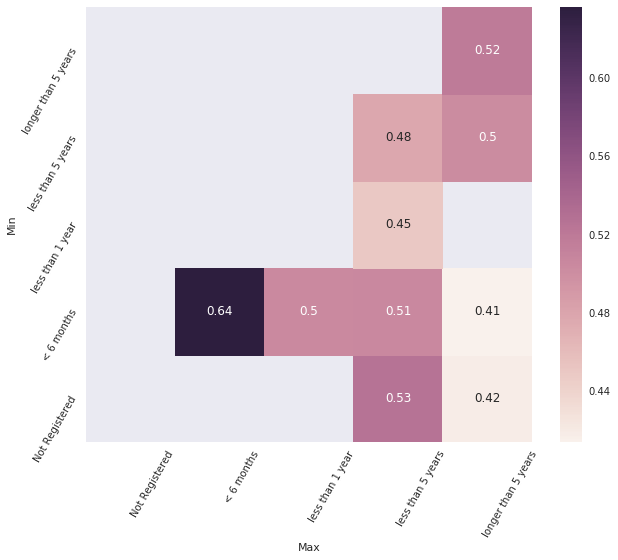

[[23, 23, 15, 82, 19], [0, 105, 67, 192, 30], [0, 1, 106, 135, 14], [5, 1, 1, 740, 122], [2, 1, 0, 0, 284]]


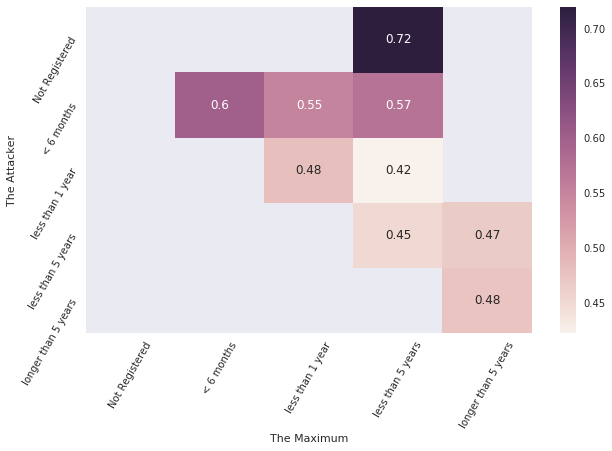

dict_keys([0, 2, -1])
[ 0.44200627  0.42570281  0.48753894  0.55847953  0.56009615]
[0.02790527857733463, 0.031916216010642505, 0.019967363475856741, 0.026916457146751741, 0.024108604274505792]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [319, 249, 642, 342, 416]
[ 0.44200627  0.42570281  0.48753894  0.55847953  0.56009615]


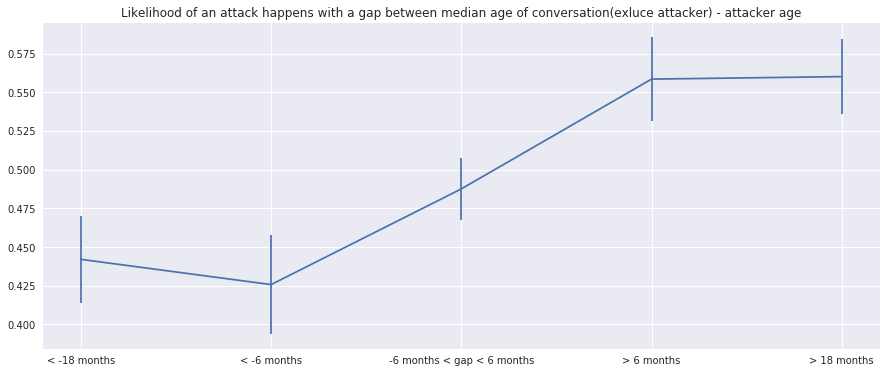

((-0.20171067181949992, 1.6301427602322248e-19),)

In [45]:
aspect = 'age'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 6, 12, 60, 180]
tile_legends = ['Not Registered', '< 6 months', 'less than 1 year', 'less than 5 years', 'longer than 5 years']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [6, 18])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap ,['< -18 months', '< -6 months', '-6 months < gap < 6 months', '> 6 months', '> 18 months'], aspect)
pearsonr(gaplst, labellst), 

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


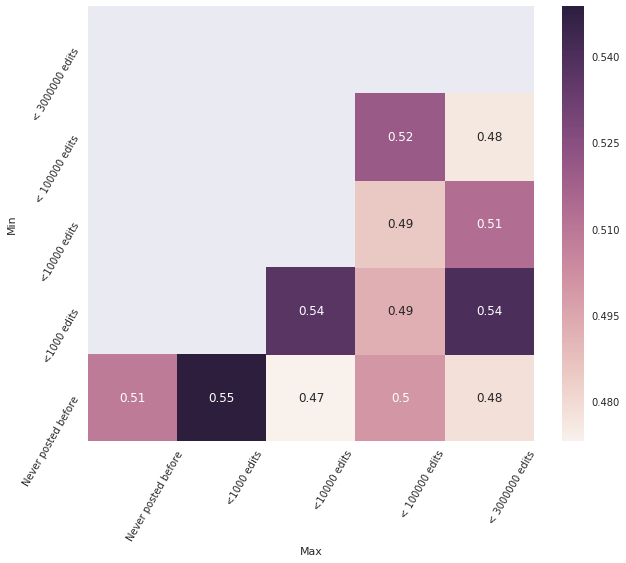

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[226, 61, 93, 147, 66], [0, 70, 37, 74, 46], [0, 0, 151, 139, 76], [0, 0, 0, 433, 125], [0, 0, 0, 0, 224]]


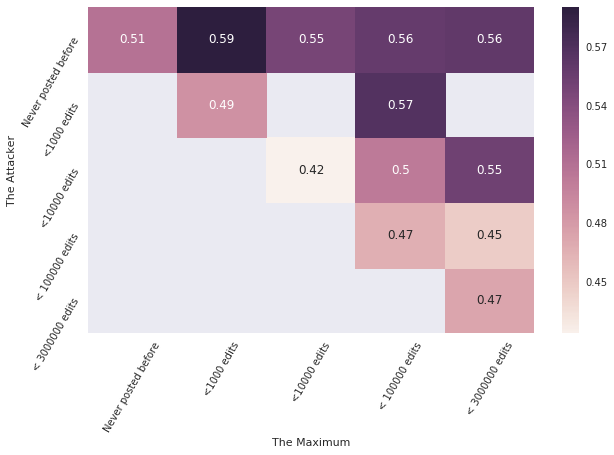

dict_keys([4, 5, 0, 3, 2])
[ 0.46774194  0.44325482  0.48387097  0.54633205  0.54314721]
[0.02795323208831391, 0.022927369954226937, 0.029988537482930094, 0.022099206654998729, 0.025465427016850867]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [310, 467, 279, 518, 394]
[ 0.46774194  0.44325482  0.48387097  0.54633205  0.54314721]


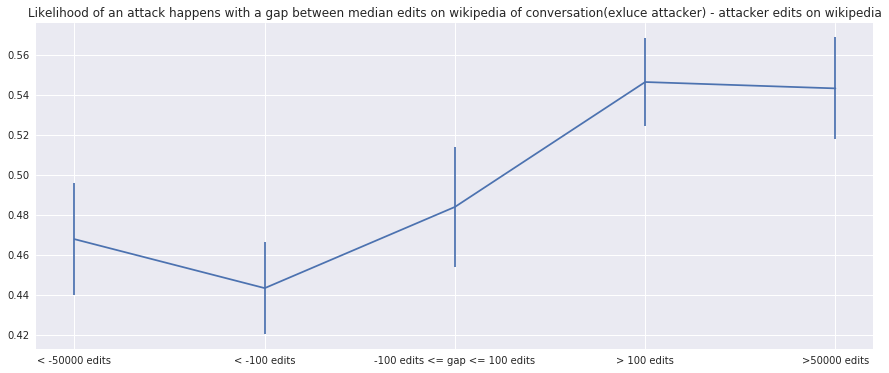

(-0.20171067181949992, 1.6301427602322248e-19)

In [46]:
aspect = 'edits_on_wikipedia_articles'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 1000, 10000, 100000, 3000000]
tile_legends = ['Never posted before', '<1000 edits', '<10000 edits', '< 100000 edits', '< 3000000 edits']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [100, 50000])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap , ['< -50000 edits', '< -100 edits', '-100 edits <= gap <= 100 edits', '> 100 edits', '>50000 edits'], 'edits on wikipedia')
pearsonr(gaplst, labellst)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


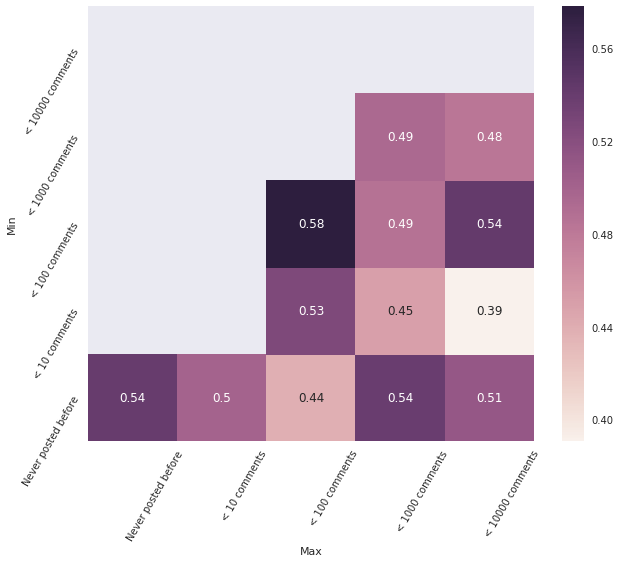

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[218, 48, 110, 162, 48], [0, 58, 29, 64, 36], [0, 0, 162, 154, 64], [0, 0, 0, 460, 126], [0, 0, 0, 0, 229]]


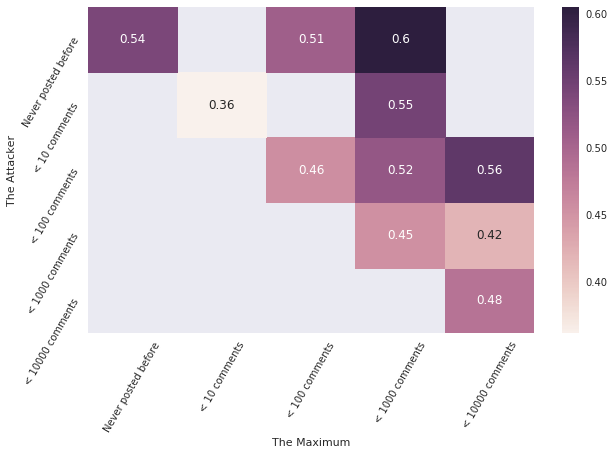

dict_keys([2, 3, 0, 4])
[ 0.5         0.43807339  0.50518135  0.53962264  0.51162791]
[0.029978003172323322, 0.024652920123696669, 0.025341246812945726, 0.022104472484300197, 0.026229732028360687]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [272, 436, 386, 530, 344]
[ 0.5         0.43807339  0.50518135  0.53962264  0.51162791]


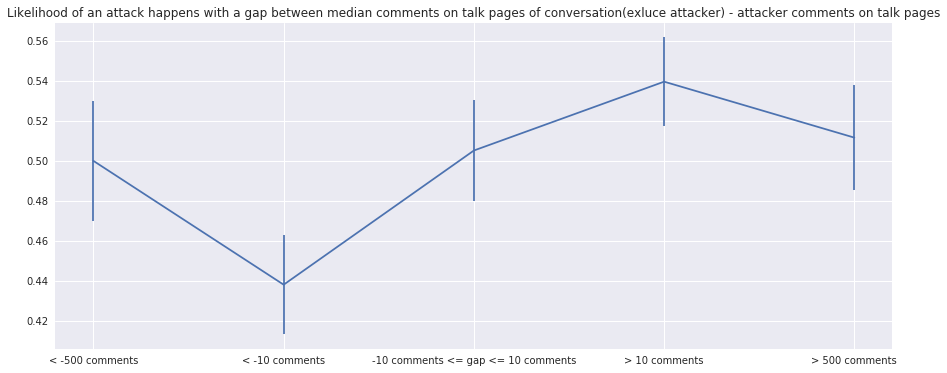

(-0.20171067181949992, 1.6301427602322248e-19)

In [47]:
aspect = 'comments_on_all_talk_pages'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 10 comments', '< 100 comments', '< 1000 comments', '< 10000 comments']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [10, 500])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap , ['< -500 comments', '< -10 comments', '-10 comments <= gap <= 10 comments', '> 10 comments', '> 500 comments'], 'comments on talk pages')
pearsonr(gaplst, labellst)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


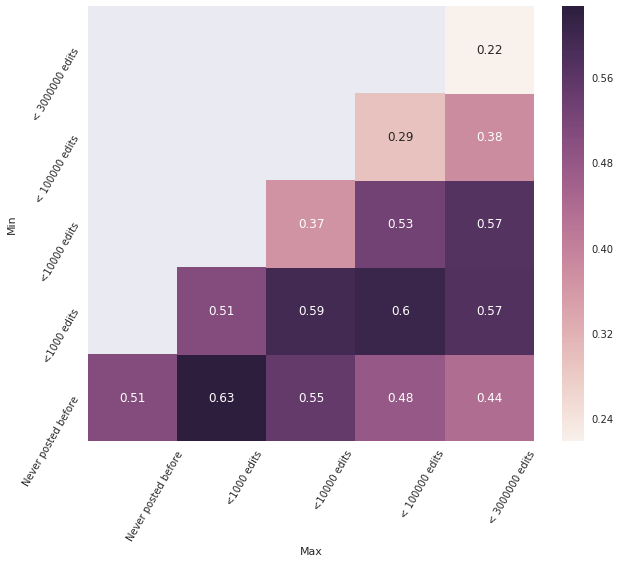

[[2491, 835, 882, 1385, 852], [0, 835, 344, 696, 453], [0, 0, 979, 592, 507], [0, 0, 0, 2125, 594], [0, 0, 0, 0, 1238]]


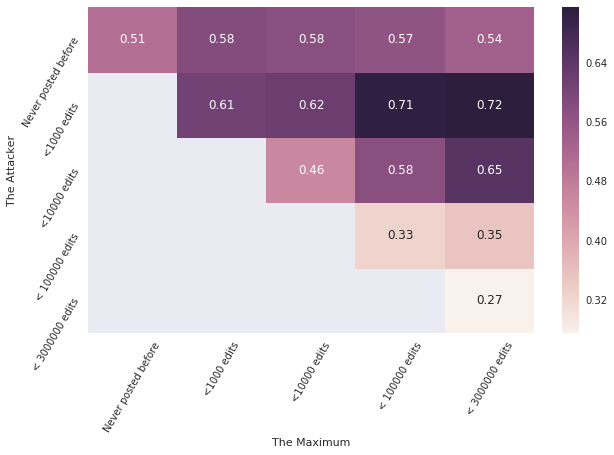

Number of conversations in the group: [6445, 2328, 2078, 2719, 1238]


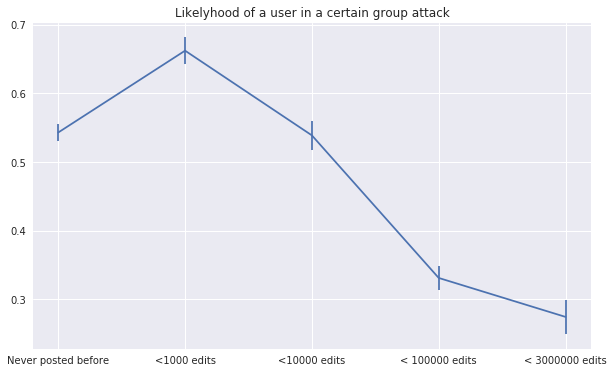

In [66]:
aspect = 'edits_on_wikipedia_articles'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 1000, 10000, 100000, 3000000]
tile_legends = ['Never posted before', '<1000 edits', '<10000 edits', '< 100000 edits', '< 3000000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


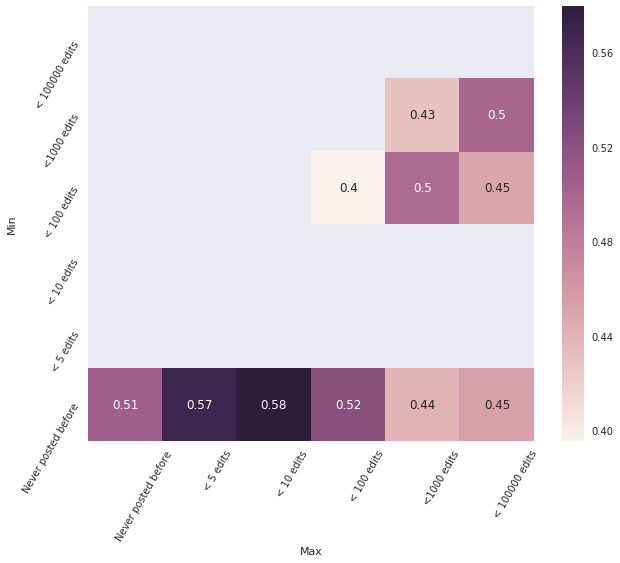

TypeError: propencity_of_attacking() missing 1 required positional argument: 'feature_sets'

In [67]:
aspect = 'edits_on_subjectpage'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 5 edits', '< 10 edits', '< 100 edits', '<1000 edits', '< 100000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [ ]:
aspect = 'comments_on_same_talk_page'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 250]
tile_legends = ['Never posted before', '< 5 comments', '< 10 comments', '> 10 comments']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [202]:
print(min(v),max(v), np.percentile(v, 25), np.percentile(v, 50), np.percentile(v, 75))

0 2450371 0.0 7364.0 55164.0


In [67]:
ASPECTS

['age',
 'status',
 'comments_on_same_talk_page',
 'comments_on_all_talk_pages',
 'edits_on_subjectpage',
 'edits_on_wikipedia_articles']

In [64]:
tiles

[0.0,
 0.0,
 0.0,
 4.0,
 30.0,
 84.0,
 171.0,
 345.0,
 662.0,
 1465.4000000000015,
 86090.0]

In [69]:
# Need to manually define tiles
aspect = ASPECTS[3]
tiles = discrepancy_heatmap(aspect, feature_sets, 5)
propencity_of_attacking(aspect, user_infos, documents, tiles, 5)

7 5 [0.0, 0.0, 30.0, 171.0, 662.0, 86090.0]


IndexError: list index out of range

# Plots and Examples

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


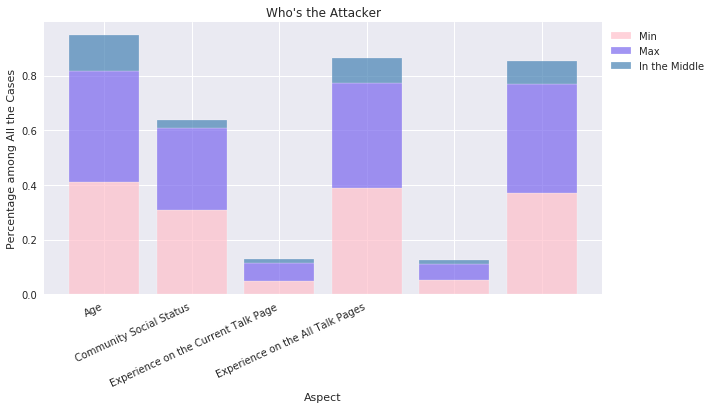

In [93]:
plot_profiles(profiles, 1, ASPECTS)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


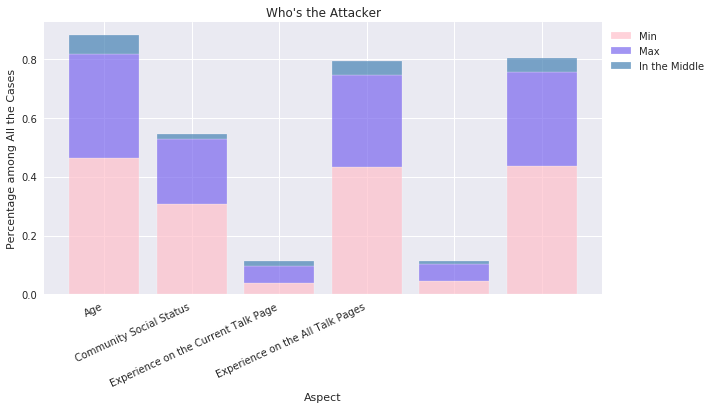

In [94]:
plot_profiles(profiles, 0, ASPECTS)

In [28]:
get_examples(documents, feature_sets, 'has_content_repeat', 1, 1, 1)

== the grim and frostbitten beginning == Here it is. It's mostly kinda minimal for now, since I've copied it all from 's pages and the parent project's pages. I haven't changed the colors yet though. That may be something to do later on. 
Navnløs
-1
ARGH! Grimmig und Erfroren!!!! I love it. I'm surprised we're even allowed to use an upside-down cross as our image thing. 
Navnløs
0
 :I have no idea if we actually are, but it was the first thing that came to my mind. We can change it if we get complaints, but I hope we won't because it's petty awesome.
5theye
1
 ::We can and will. If you get any Christian types complaining, send them towards [WP:CENSORED], and tell them [Cross of St. Peter@that they really need to learn a little about their own religion].
J Milburn
2
It is pretty awesome. J Milburn' is right about wikipedia not being censored and I realize the inverted cross is actually originally a Christian symbol (and still is; though uncommon), but it's obvious we're not using it tha

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


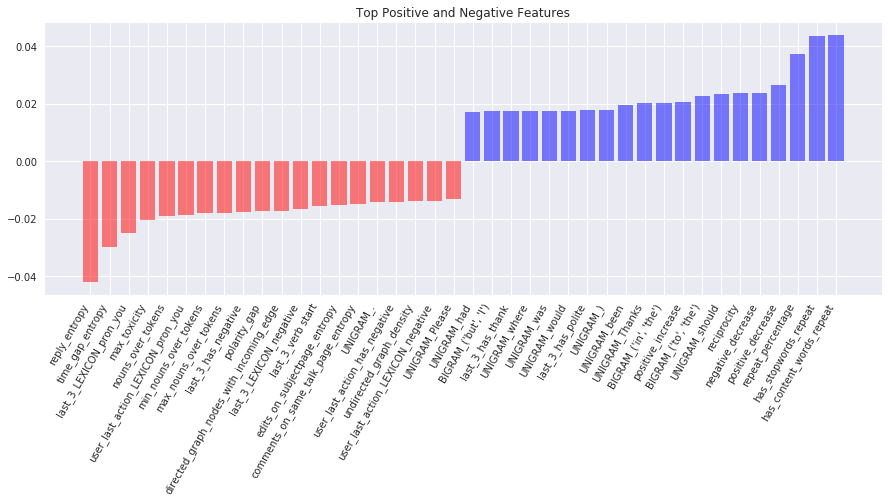

In [46]:
classifier = linear_model.LogisticRegression(C=0.0007)
classifier.fit(X, y)
top_pos, top_neg= plot_coefficients(classifier, feature_names, 20)
#0.630 (+/-0.007) for {'C': 0.0006}

In [44]:
plot_feature_distribution(feature_sets, top_pos)

NameError: name 'plot_feature_distribution' is not defined

finish collecting


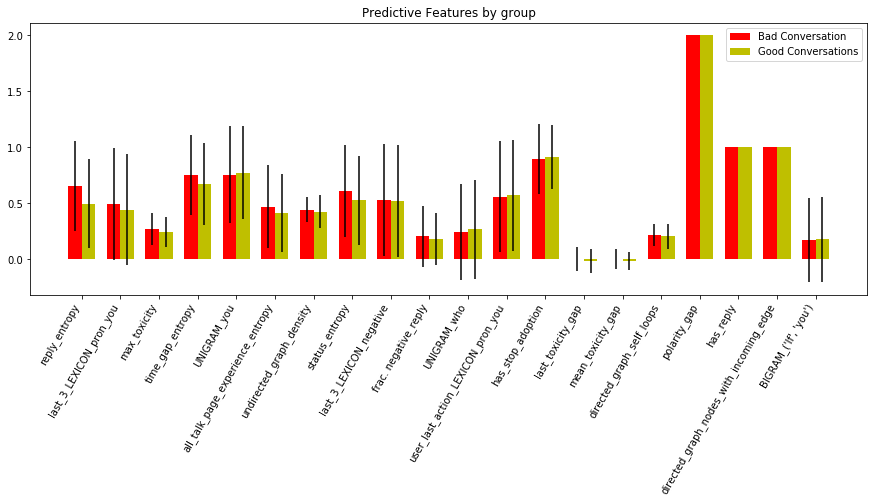

In [178]:
plot_feature_distribution(feature_sets, top_neg)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


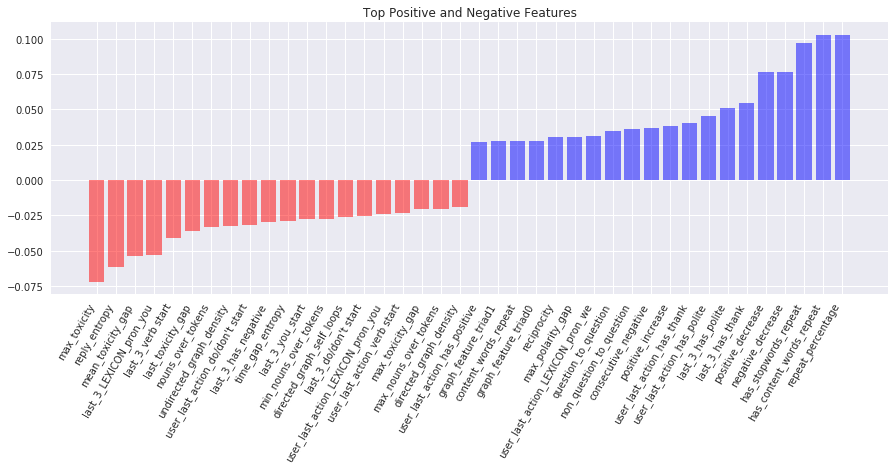

In [26]:
classifier = svm.LinearSVC(C=0.001)
classifier.fit(X, y)
top_pos, top_neg = plot_coefficients(classifier, feature_names, 20)
# bow + action(last 3 actions) + repeat + entropy
# 0.655 (+/-0.007) for {'C': 0.0006}

In [ ]:
# Output Feature Names

In [148]:
negative_features = {c:[] for c in constraints}
positive_features = {c:[] for c in constraints}

In [206]:
negative_features[constraint].append(yy)
positive_features[constraint].append(xx)

In [209]:
for n in negative_features.keys():
    negative_features[n] = negative_features[n][0]

In [210]:
for n in positive_features.keys():
    positive_features[n] = positive_features[n][0]

In [211]:
pd.DataFrame.from_dict(negative_features).to_csv('feature_results_negative.csv', index=False)

In [212]:
pd.DataFrame.from_dict(positive_features).to_csv('feature_results_positive.csv', index=False)

# Spearman Correlation

In [874]:
corr = []
pval = []
names = []
for key in features_corr:
    x,p = spearmanr(number_users, features_corr[key])
    corr.append(x)
    pval.append(p)
    names.append(key)


N = len(corr)

ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

#plt.subplots()
plt.figure(figsize=(15, 5))
plt.bar(ind, corr, width, color='green', alpha=0.5, yerr=pval)

# add some text for labels, title and axes ticks
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between graph features and number of users')
plt.xticks(ind, names, rotation=60, ha='right')
#ax.set_xticklabels(names)

plt.show()